In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
from datetime import date

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
training_data = loadtxt(f"batch_1_to_5.csv", delimiter=',')
training_data

array([[42.738, 20.028, 37.234, 78.202, 1.747, 464.793, 48.990, -6.730],
       [35.410, 63.615, 0.975, 72.708, 4.089, 128.993, 25.616, -43.130],
       [38.607, 31.172, 30.221, 66.877, 2.993, 91.991, 29.951, -17.330],
       [70.546, 21.700, 7.754, 71.495, 0.604, 147.951, 64.000, 7.760],
       [32.484, 47.606, 19.910, 62.353, 4.338, 268.694, 23.035, -32.220],
       [2.183, 47.834, 49.983, 60.888, 0.193, 227.405, 0.921, -42.530],
       [26.227, 3.214, 70.558, 73.616, 1.308, 298.860, 42.261, 12.760],
       [46.493, 8.374, 45.133, 65.425, 3.356, 41.452, 58.352, 13.640],
       [27.885, 56.712, 15.403, 69.485, 0.953, 351.240, 17.621, -38.710],
       [27.256, 28.335, 44.409, 64.019, 2.528, 381.236, 19.403, -24.740],
       [26.061, 39.625, 34.314, 78.693, 4.944, 438.393, 19.361, -30.650],
       [7.099, 50.405, 42.496, 75.713, 2.373, 198.215, 4.816, -41.710],
       [10.602, 33.869, 55.529, 69.391, 0.053, 82.476, 8.869, -32.170],
       [35.819, 10.306, 53.875, 69.788, 4.931, 126.998,

In [3]:
####################
# initialization

n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([-50, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

lower_bounds = torch.tensor([5.0, 5.0, 5.0, 60, 0.01, 60.0], **tkwargs) 
upper_bounds = torch.tensor([95.0, 95.0, 95.0, 80, 5.0, 480.0], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

BATCH_SIZE = 12

In [4]:
# set the tensor according to latest cumulative dataset
train_x = torch.tensor(training_data[:,:n_var], **tkwargs)
train_obj = torch.tensor(training_data[:,n_var:n_var+n_obj], **tkwargs)

# we need to do some scaling for the outputs
# output 1 for styrene% should be converted to negative to force minimization
# output 2 for TG needs to be scaled to ensure maximization
train_obj[:,0] = -train_obj[:,0]
output_lower = train_obj[:,1].min()
output_upper = train_obj[:,1].max()
output_bounds = torch.vstack([output_lower, output_upper])
train_obj[:,1] = normalize(train_obj[:,1], output_bounds)

C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


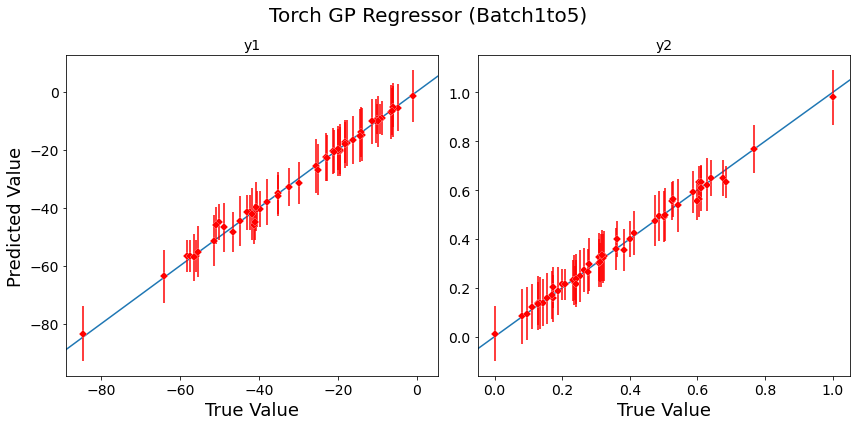

In [5]:
####################
# surrogate model

train_x_gp = normalize(train_x, problem_bounds)

# form the output train_y data by concentenating train_obj with train_con 
# this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
#train_y = torch.cat([train_obj, train_con], dim=-1)
train_y = train_obj

# define and train surrogate models for objective and constraint
models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model1 = ModelListGP(*models)
mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

fit_gpytorch_model(mll1) 

model1.eval()

with torch.no_grad():
    y_true = train_y
    posterior = model1.posterior(train_x_gp)  
    y_pred = posterior.mean.squeeze()
    lower, upper = posterior.mvn.confidence_region()
    yerr = upper-lower
    
    random_samples = draw_sobol_samples(bounds=standard_bounds,n=516, q=1).squeeze(1)
    posterior1 = model1.posterior(random_samples)  
    y_pred1 = posterior1.mean.squeeze()
    lower1, upper1 = posterior1.mvn.confidence_region()
    yerr1 = upper1-lower1
    
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

for i, obj in zip([0,1], ["y1", 'y2']):

        ax[i].axline((1, 1), slope=1)
        

        ax[i].errorbar(x=y_true[...,i].cpu().numpy(), y=y_pred[...,i].cpu().numpy(), yerr=yerr[...,i].cpu().numpy(),
                       ls='', marker='D', mec='w', mew=0.2, mfc='r', c='r', 
                        #label='{:} R$^2$={:.3f}'.format(s,r2)
                       )
        


        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('Torch GP Regressor (Batch1to5)')
fig.tight_layout()


In [6]:
####################    
# acquisition function

acq_func1 = qNoisyExpectedHypervolumeImprovement(
    model=model1,
    ref_point=ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x_gp, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(num_samples=512),  # determines how candidates are randomly proposed before selection
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()), # optimize first n_obj col 
    #constraints=create_idxrs(), # constraint on last n_constr col
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

sobol1 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
sobol2 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
sobol_all = torch.vstack([sobol1, sobol2])

# perform repair on x0-3 to get 100%
for i in range(0,sobol_all.shape[0]):
    sobol_all[i,:3] = sobol_all[i,:3]/sobol_all[i,:3].sum()
    
acq_value_list = []
for i in range(0, sobol_all.shape[0]):
    with torch.no_grad():
        acq_value = acq_func1(sobol_all[i].unsqueeze(dim=0))
        acq_value_list.append(acq_value.item())
        
# filter the best 4 QMC candidates first
sorted_x = sobol_all.cpu().numpy()[np.argsort((acq_value_list))]
qnehvi_x = torch.tensor(sorted_x[-12:], **tkwargs)  
# unormalize our training inputs back to original problem bounds
new_x =  unnormalize(qnehvi_x, bounds=problem_bounds)

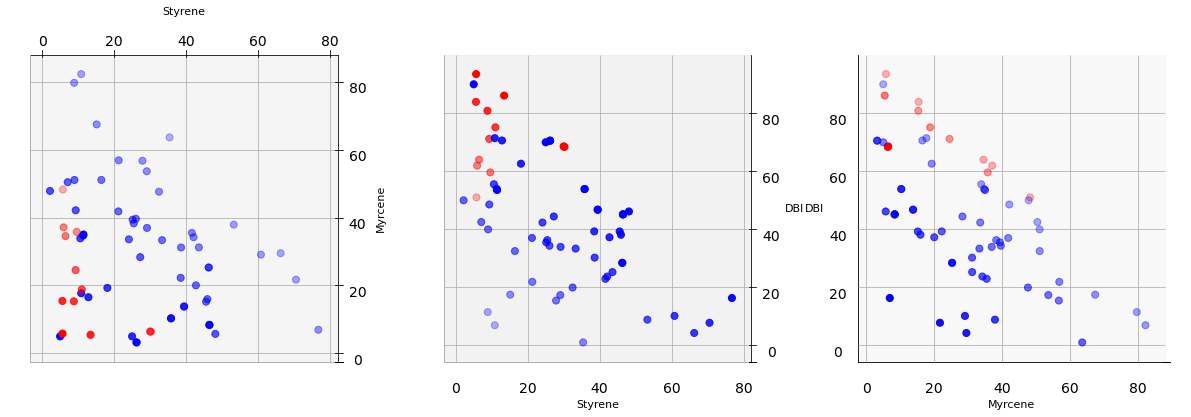

In [7]:
new_x_plot = new_x.cpu().numpy()
train_x_plot = train_x.cpu().numpy()

# (plane, (elev, azim, roll))
views = [('XY',   (90, -90, 0)),
         ('XZ',    (0, -90, 0)),
         ('YZ',    (0,   0, 0)),]
         
layout = [['XY', 'XZ', 'YZ']]  

fig, axd = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                              figsize=(21, 7))
         
for plane, angles in views:
    
    if plane == 'XY':
        axd[plane].set_xlabel('Styrene', fontsize=11)
        axd[plane].set_ylabel('Myrcene', fontsize=11)

        axd[plane].set_zticklabels([])
        axd[plane].set_zlabel('')
        
    if plane == 'XZ':
        axd[plane].set_xlabel('Styrene', fontsize=11)
        axd[plane].set_zlabel('DBI', fontsize=11)
        
        axd[plane].set_yticklabels([])
        axd[plane].set_ylabel('')
        
    if plane == 'YZ':
        axd[plane].set_ylabel('Myrcene', fontsize=11)
        axd[plane].set_zlabel('DBI', fontsize=11)
        
        axd[plane].set_xticklabels([])
        axd[plane].set_xlabel('')
    
    axd[plane].set_proj_type('ortho')
    axd[plane].view_init(elev=angles[0], azim=angles[1])
    axd[plane].set_box_aspect((1,1,1), zoom=1.5)
    
    axd[plane].scatter3D(train_x_plot[:,0], train_x_plot[:,1], train_x_plot[:,2], s=50, c='b')   
    axd[plane].scatter3D(new_x_plot[:,0], new_x_plot[:,1], new_x_plot[:,2], s=50, c='r')   

    

In [35]:
import matplotlib.patches as patches

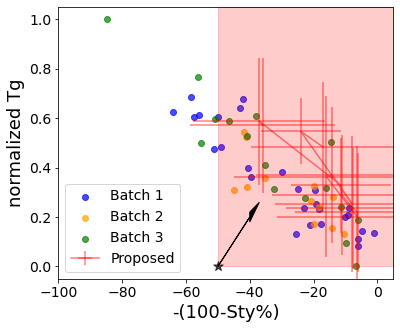

In [90]:
with torch.no_grad():
    posterior = model1.posterior(qnehvi_x)  
    y_pred = posterior.mean.squeeze()
    lower, upper = posterior.mvn.confidence_region()
    yerr = upper-lower

train_obj_plot = train_obj.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(train_obj_plot[:27][:,0],
           train_obj_plot[:27][:,1],
           label=f'Batch 1', c='b', alpha=0.7)


ax.scatter(train_obj_plot[27:39][:,0],
           train_obj_plot[27:39][:,1],
           label=f'Batch 2', c='orange', alpha=0.7)

ax.scatter(train_obj_plot[39:][:,0],
           train_obj_plot[39:][:,1],
           label=f'Batch 3', c='g', alpha=0.7)

ax.scatter(ref_point.cpu().numpy()[0],
           ref_point.cpu().numpy()[1],
           marker='*', c='k', alpha=0.7, s=100)

ax.errorbar(y_pred.cpu().numpy()[:,0], y_pred.cpu().numpy()[:,1], xerr=yerr.cpu().numpy()[:,0], yerr=yerr.cpu().numpy()[:,1],
           label=f"Proposed", c='r',alpha=0.5)

rect = patches.Rectangle((-50, 0), 55, 1.05, linewidth=1, edgecolor='r', facecolor='r', alpha=0.2)
ax.add_patch(rect)

plt.arrow(-50, 0, 10, 0.2, head_width=0.04, head_length=3, color='black')

ax.set_xlim(-100.0, 5.0)
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel('-(100-Sty%)')
ax.set_ylabel('normalized Tg')
ax.legend()

In [6]:
# Save Batch 6 Data

cols = ['Styrene (mol %)', 'Myrcene (mol %)', 'DBI (mol %)', 'Temperature (deg C)', 'AIBN (mol %)', 'Time (min)']
new_x  = pd.DataFrame(new_x.cpu().numpy() , columns = cols) # new_x needs to be transferred back to cpu and then to numpy
new_x.to_excel('23-01-16 Batch 6 Datapoints.xlsx')